In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import visualkeras

# Paramètres de base

In [35]:
input_shape = (128, 128, 3)
batch_size = 32
epochs = 50
learning_rate = 1e-5  

In [19]:
base_dir = os.getcwd()
relative_path = r"..\..\DataSets\Rebanced_DataSets\augmentation"
dataset_dir = os.path.normpath(os.path.join(base_dir, relative_path))

In [20]:
# Charger le jeu de données d'entraînement
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(128, 128),
    batch_size=batch_size
)

# Charger le jeu de données de validation
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(128, 128),
    batch_size=batch_size
)

Found 46471 files belonging to 2 classes.
Using 37177 files for training.
Found 46471 files belonging to 2 classes.
Using 9294 files for validation.


In [21]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_set = train_set.map(lambda x, y: (normalization_layer(x), y))
test_set = test_set.map(lambda x, y: (normalization_layer(x), y))

In [22]:
def build_encoder(input_shape):
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return Model(input_img, encoded)


encoder = build_encoder(input_shape)

In [27]:
def build_encoder_classifier(encoder, input_shape):
    model = Sequential()
    model.add(encoder)  
    model.add(Flatten()) 
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model

In [28]:
encoder_classifier = build_encoder_classifier(encoder, input_shape)

In [29]:
encoder_classifier.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_6 (Functional)       │ (None, 16, 16, 64)     │        19,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,411,073 (32.09 MB)

 Trainable params: 8,410,049 (32.08 MB)

 Non-trainable params: 1,024 (4.00 KB)

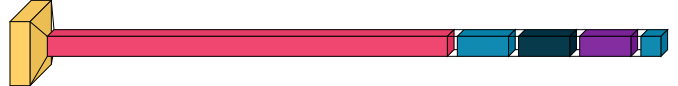

In [31]:
visualkeras.layered_view(encoder_classifier).show() # display using your system viewer
visualkeras.layered_view(encoder_classifier, to_file='output.png') # write to disk
visualkeras.layered_view(encoder_classifier, to_file='output.png').show() # write and show

visualkeras.layered_view(encoder_classifier)

# Enregistrement des meilleurs modèles pendant l'entraînement

In [32]:
classification_checkpoint = ModelCheckpoint('classification_best.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)


### TensorBoard pour visualiser l'entraînement

In [33]:
# TensorBoard pour visualiser l'entraînement
log_dir = os.path.join("logs", "classification")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Entraîner le modèle de classification

In [36]:

history = encoder_classifier.fit(
    train_set,
    epochs=epochs,
    validation_data=test_set,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
        classification_checkpoint,
        tensorboard_callback
    ]
)

Epoch 1/50


1162/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8652 - loss: 0.3608 - precision_2: 0.8345 - recall_2: 0.9134
Epoch 1: val_loss improved from inf to 0.24909, saving model to classification_best.keras
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 280s 241ms/step - accuracy: 0.8652 - loss: 0.3608 - precision_2: 0.8345 - recall_2: 0.9134 - val_accuracy: 0.8992 - val_loss: 0.2491 - val_precision_2: 0.9027 - val_recall_2: 0.8936 - learning_rate: 1.0000e-05
Epoch 2/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9111 - loss: 0.2466 - precision_2: 0.8787 - recall_2: 0.9551
Epoch 2: val_loss improved from 0.24909 to 0.20311, saving model to classification_best.keras
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 261s 225ms/step - accuracy: 0.9111 - loss: 0.2466 - precision_2: 0.8787 - recall_2: 0.9551 - val_accuracy: 0.9246 - val_loss: 0.2031 - val_precision_2: 0.8939 - val_recall_2: 0.9626 - learning_rate: 1.0000e-05
Epoch 3/50
1162/1162 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.9226 - loss: 

In [39]:
def plot_training(history):
    plt.figure(figsize=(12, 10))  # Augmente la taille pour mieux visualiser
    
    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    
    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over epochs')
    
    # Precision
    plt.subplot(2, 2, 3)
    plt.plot(history.history['precision_2'], label='Train Precision')
    plt.plot(history.history['val_precision_2'], label='Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision over epochs')
    
    # Recall
    plt.subplot(2, 2, 4)
    plt.plot(history.history['recall_2'], label='Train Recall')
    plt.plot(history.history['val_recall_2'], label='Validation Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.title('Recall over epochs')
    
    plt.tight_layout()
    plt.show()


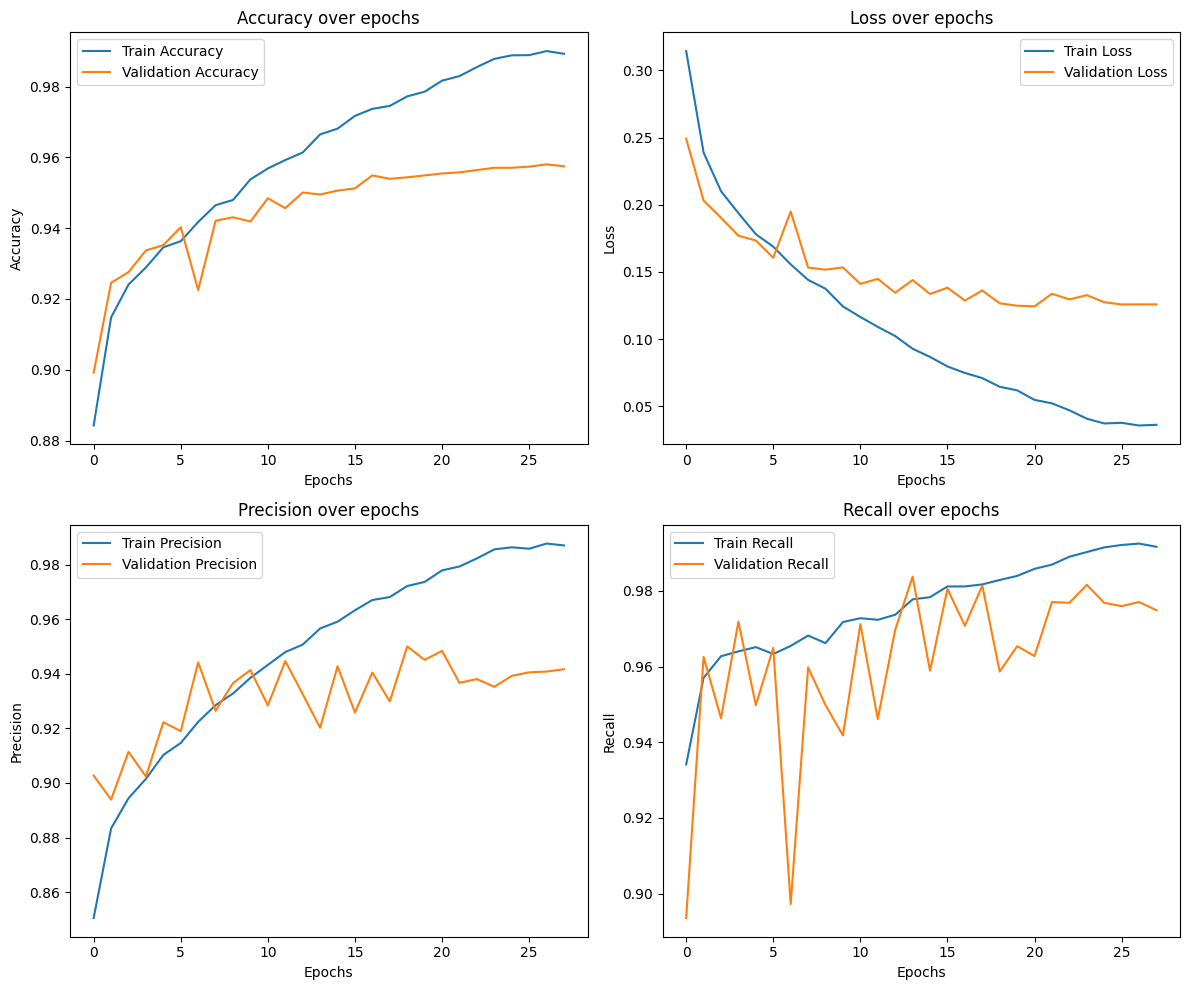

In [40]:
plot_training(history)

#### Accuracy Over Epochs:

The train accuracy continues to improve over the epochs, approaching almost 99%, which indicates that the model is learning well on the training data.
The validation accuracy stabilizes around 95%, with minor fluctuations, indicating a good generalization to the validation data without significant overfitting.
#### Loss Over Epochs:

The train loss consistently decreases, reflecting better optimization of the model.
The validation loss decreases at a slower rate, but overall follows the trend of improvement. There are minor fluctuations, which could suggest some variability in the validation set, but it doesn’t seem alarming.
#### Precision Over Epochs:

Both train precision and validation precision are improving steadily. Validation precision is slightly lower but still remains high, which means that the model is making fewer false positives as training progresses.
#### Recall Over Epochs:

Train recall shows consistent improvement, indicating that the model is increasingly catching more true positives over time.
Validation recall fluctuates a bit, but the trend is generally stable and high, suggesting the model performs well on the validation set in identifying true positives, despite some volatility.
Overall Conclusion:
The model appears to be performing well, with high accuracy, precision, and recall on both the training and validation sets. There is no sign of severe overfitting, as the validation metrics track closely to the training metrics. Minor fluctuations in validation precision and recall are natural and may improve further with additional fine-tuning or regularization. The loss curves indicate that the model continues to improve, with validation loss stabilizing over time.

This performance is strong, suggesting that the model is well-trained and generalizes well to unseen data. You could experiment with further tuning (via techniques like Grid Search or additional regularization) if needed, but this looks promising for your task.

# Sauvegarder les poids après l'entraînement

In [42]:
encoder_classifier.save_weights('encoder_classifier.weights.h5')

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Fonction de prédiction avec probabilités
def predict_image_binary_with_probabilities(model_save, image_path):
    img = load_img(image_path, target_size=(128, 128))  # Adapter la taille à celle du modèle
    img_array = img_to_array(img)  # Conversion en tableau numpy
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter la dimension batch
    img_array /= 255.0  # Normalisation de l'image

    # Prédiction binaire (probabilité unique)
    predictions = model_save.predict(img_array)
    probability = predictions[0][0]  # Probabilité que l'image soit une "Photo"
    
    # Classification basée sur la probabilité
    if probability > 0.5:
        predicted_class = 'Photo'
    else:
        predicted_class = 'Not-Photo'  # "Image" comme Not-Photo dans ce cas

    # Retourner la classe prédite et les probabilités (classe photo et non-photo)
    return predicted_class, [probability, 1 - probability]

# Fonction d'affichage des images avec probabilités
def display_images_with_binary_probabilities(model_save, dataset_dir, num_images=6):
    subfolders = ['Painting', 'Schematics', 'Sketch', 'Text']  # Liste des sous-dossiers d'images
    folder = ["Image","photo"]
    fig, axes = plt.subplots(2, num_images//2, figsize=(18, 8))  # Créer une grille pour afficher les images

    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']  # Extensions d'images valides

    for i in range(num_images):
        randomfolder = random.choice(folder) 
        if randomfolder == "photo":
             image_folder = os.path.join(dataset_dir, randomfolder) 
        else:
            subfolder = random.choice(subfolders)
            image_folder = os.path.join(dataset_dir, randomfolder, subfolder)  

        # Vérifier l'existence du sous-dossier
        if not os.path.exists(image_folder):
            print(f"Folder not found: {image_folder}")
            continue
        
        try:
            # Fichiers valides dans le sous-dossier
            valid_files = [f for f in os.listdir(image_folder) if os.path.splitext(f)[1].lower() in valid_extensions]
            
            if len(valid_files) == 0:
                print(f"No valid image files found in: {image_folder}")
                continue

            random_image = random.choice(valid_files)
            image_path = os.path.join(image_folder, random_image)

            # Charger l'image et obtenir la prédiction
            img = load_img(image_path, target_size=(256, 256))  # Pour une meilleure visibilité
            predicted_class, probabilities = predict_image_binary_with_probabilities(model_save, image_path)

            # Sélectionner l'emplacement dans la grille (axes)
            ax = axes[i // (num_images // 2), i % (num_images // 2)]
            ax.imshow(img)
            ax.axis('off')

            # Afficher la classe prédite et le pourcentage
            probability_photo = probabilities[0] * 100  # Probabilité que ce soit une "Photo"
            ax.set_title(f'Predicted Class: {predicted_class} ({probability_photo:.2f}%)', fontsize=12)

        except Exception as e:
            print(f"An error occurred: {e}")
            ax.text(0.5, 0.5, 'Image Not Found', horizontalalignment='center', verticalalignment='center', fontsize=14)
            ax.axis('off')
            continue

    plt.tight_layout()
    plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
An error occurred: index 2 is out of bounds for axis 0 with size 2


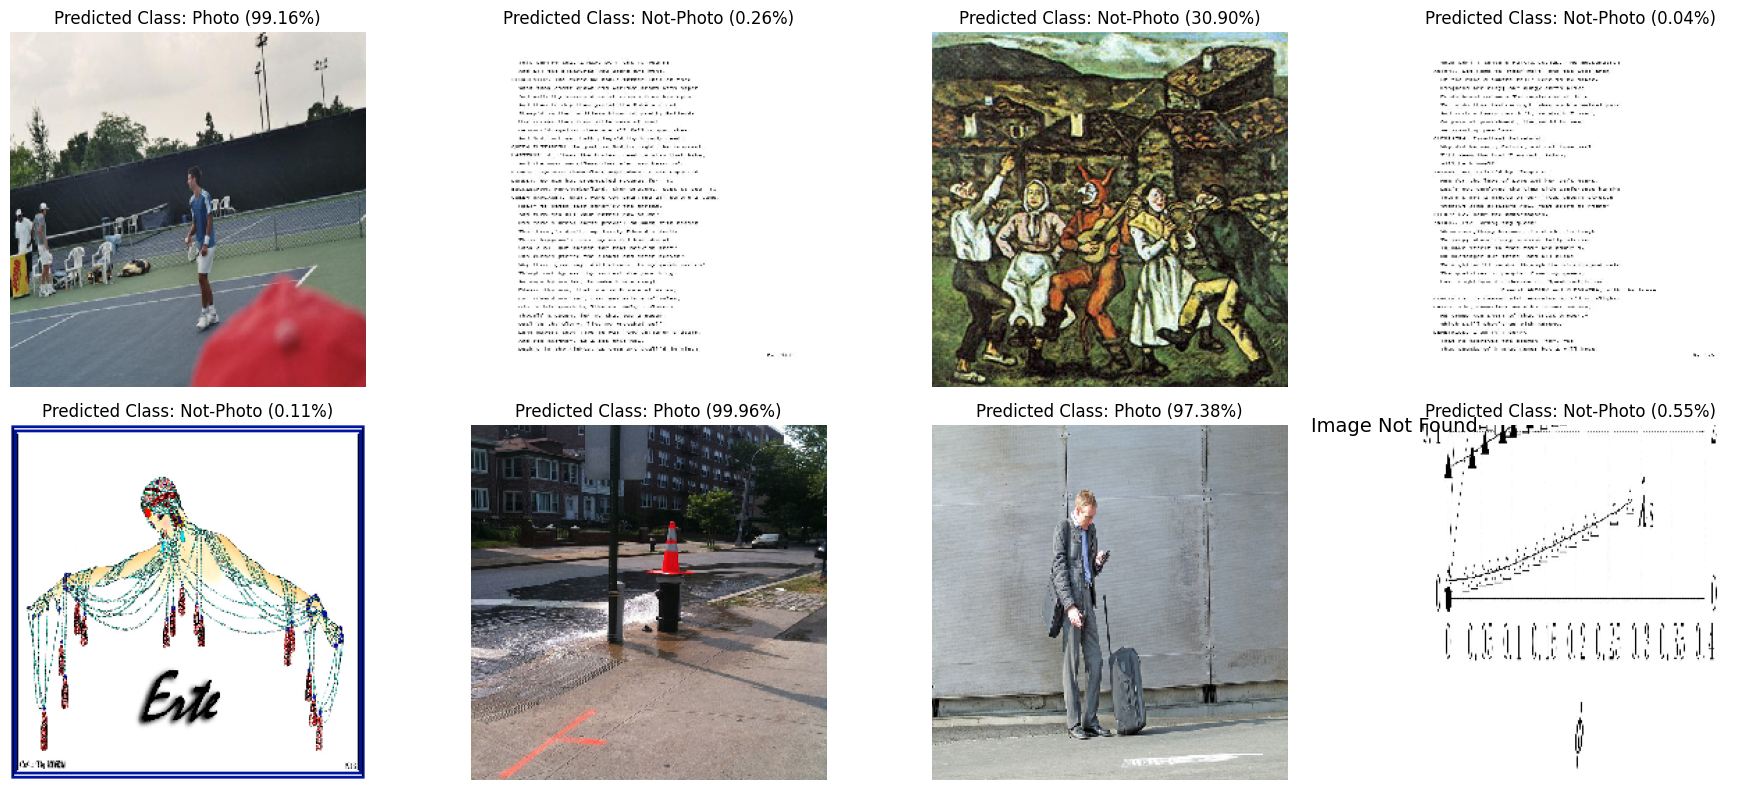

In [44]:
display_images_with_binary_probabilities(encoder_classifier, dataset_dir, num_images=9)

# Utilisation des Poids Sauvegarder


In [45]:
# Utilisation des Poids Sauvegarder
save_weights_encoder_classifier = build_encoder_classifier(encoder, input_shape)

In [46]:
save_weights_encoder_classifier.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
save_weights_encoder_classifier.load_weights('encoder_classifier.weights.h5')

c:\Users\steve\Documents\GitHub\DataSciencePictureDesc\data-science-env\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
An error occurred: index 2 is out of bounds for axis 0 with size 2


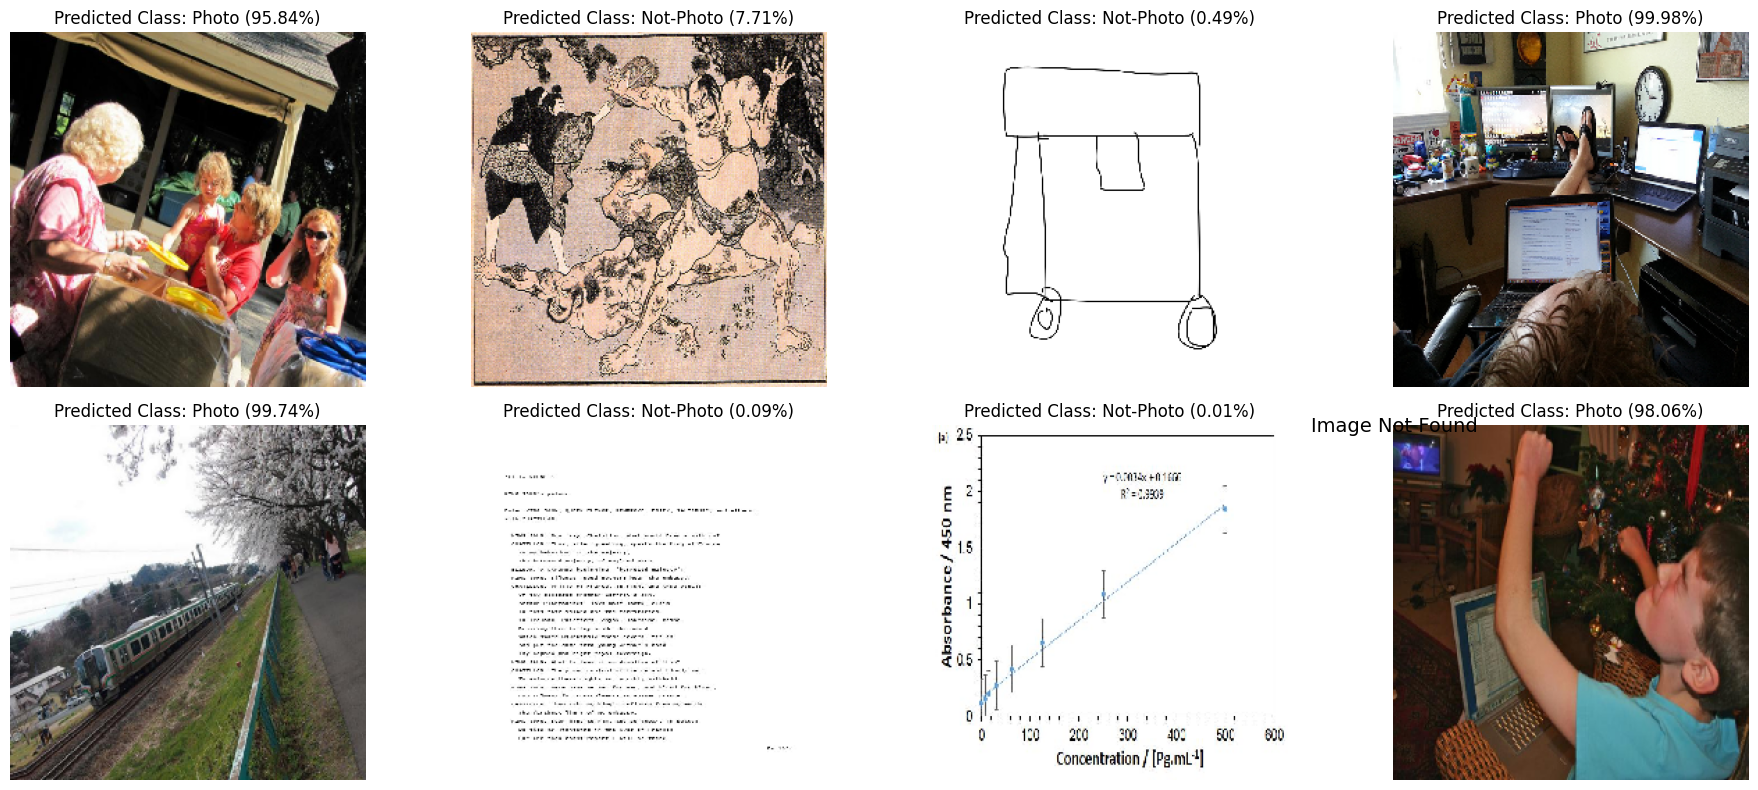

: 

In [49]:
display_images_with_binary_probabilities(save_weights_encoder_classifier, dataset_dir, num_images=9)